<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/Ship_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting the data

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Ships/train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.5, max_zoom=1.2, max_warp=0.2)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
src = (ImageList.from_csv(path, 'train.csv', folder='images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
#File based
np.random.seed(42)
data = ImageDataBunch.from_csv(path, 
                        folder='images',
                        csv_labels='train.csv',
                        fn_col=0, label_col=1,
                        ds_tfms=get_transforms(tfms),                       
                        size=128, valid_pct=0.2)

In [0]:
test = ImageList.from_csv(path, 'test.csv', folder='images')

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['1', '2', '3', '4', '5'], 5, 5002, 1250)

`show_batch` still works, and show us the different labels separated by `;`.

In [0]:
data.show_batch(rows=3, figsize=(7,6))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 21114630.59it/s]


In [0]:
del learn
gc.collect()

67

In [0]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.377518,0.217551,0.895520,0.821924,19:42
1,0.231361,0.150568,0.924960,0.872000,00:35
2,0.172270,0.128875,0.933120,0.892971,00:35
3,0.139200,0.113426,0.944480,0.911371,00:34
4,0.124869,0.110855,0.946240,0.916705,00:34


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


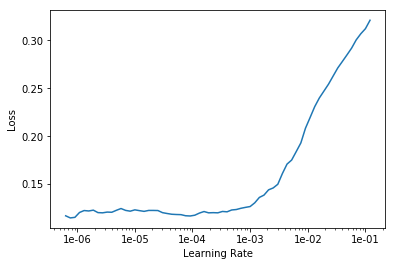

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.118035,0.106619,0.949120,0.917371,00:36
1,0.102941,0.093419,0.956480,0.930781,00:36
2,0.088093,0.093085,0.957600,0.929333,00:36


In [0]:
#learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [0]:
learn.save('stage-2-rn50')

In [0]:
learn.load('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


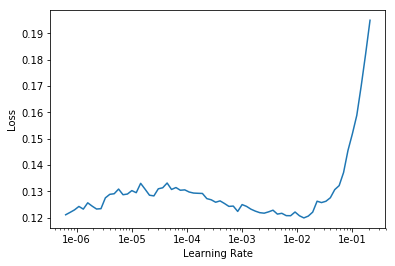

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-04,2e-02))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.113469,0.099320,0.956640,0.924610,01:22
1,0.111894,0.093472,0.964640,0.927467,01:21
2,0.097296,0.076031,0.966080,0.939733,01:21
3,0.070739,0.060473,0.972000,0.951333,01:21
4,0.058019,0.062064,0.971840,0.954000,01:21


In [0]:
learn.save('stage-2-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


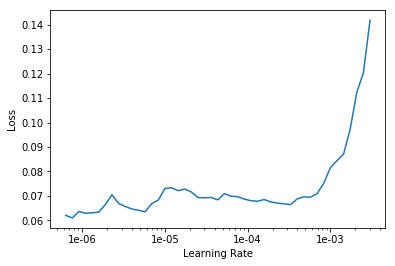

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(5e-07,1e-06))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.061126,0.061513,0.971360,0.950400,01:27
1,0.056803,0.061123,0.972960,0.952400,01:28
2,0.056778,0.062033,0.972160,0.952571,01:28


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.load('stage-1-256-rn50')

In [0]:
data = (src.transform(tfms, size=300)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 300, 300])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


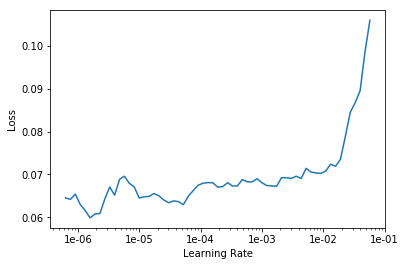

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(7e-07,1e-06))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.073353,0.037614,0.981760,0.971867,06:00
1,0.072406,0.037557,0.982720,0.973733,01:40
2,0.070775,0.038109,0.981120,0.970705,01:41


In [0]:
learn.save('stage-1-300-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


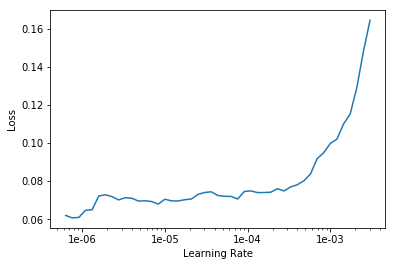

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, max_lr=slice(5e-07,1e-06))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.065238,0.036837,0.983200,0.972667,01:47


In [0]:
learn.save('stage-2-300-rn50')

In [0]:
learn.load('stage-2-300-rn50')

In [0]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

In [0]:
interp.plot_confusion_matrix()

#Results

In [0]:
test = ImageList.from_csv(path, 'test.csv', folder='images')
len(test)

2680

In [0]:
log_preds, y = learn.to_fp32().TTA(ds_type=DatasetType.Test)
pred = np.argmax(log_preds.numpy(), axis=1)

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
test_preds, test_ys = learn.TTA(ds_type=DatasetType.Test)